# 02 — KPI Computation & Dashboard Payload

**Overview**
- Load the cleaned Superstore snapshot
- Compute core KPIs (revenue, profit, avg order value, margin)
- Produce time-series visualizations (daily/weekly + rolling)
- Breakdown revenue by Category & Region
- Identify negative-profit orders
- Produce anomaly table (z-score based)
- Export a JSON dashboard payload for downstream agents


In [1]:
# Environment & imports
import sys, platform, json
from pathlib import Path
print("Python", sys.version)
print("Platform", platform.platform())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Local agent imports

sys.path.append('../')
from agents.kpi_agent import KPIAgent

# Paths
SNAPSHOT = Path("../data/processed/superstore_clean.parquet")
OUTPUT_DIR = Path("../outputs")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print("Snapshot exists:", SNAPSHOT.exists())


Python 3.12.12 | packaged by conda-forge | (main, Oct 22 2025, 23:13:34) [MSC v.1944 64 bit (AMD64)]
Platform Windows-11-10.0.26200-SP0
Snapshot exists: True


## 1) Load snapshot (fast) and quick validation


In [2]:
# Load snapshot (parquet)
if not SNAPSHOT.exists():
    raise FileNotFoundError(f"Snapshot not found at {SNAPSHOT}. Run ingestion first.")
df = pd.read_parquet(SNAPSHOT)
print("Loaded snapshot:", df.shape)
display(df.head(3))

# Defensive cleaning (fill numeric NaNs critical to KPIs)
for col in ["Sales", "Profit", "Quantity", "Discount"]:
    if col in df.columns:
        df[col] = df[col].fillna(0)

Loaded snapshot: (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


## 2) Ensure datetimes and minimal cleaning


In [3]:
# Ensure Order Date is datetime
if "Order Date" in df.columns and not pd.api.types.is_datetime64_any_dtype(
    df["Order Date"]
):
    df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
    null_dates = df["Order Date"].isna().sum()
    print(f"Order Date NaT count after parse: {null_dates}")

# Basic NA summary
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts[na_counts > 0])

Series([], dtype: int64)

## 3) Instantiate KPIAgent and get a summary


In [4]:
kpi = KPIAgent(df)
summary = kpi.summary()
print("KPI Summary:")
display(summary)

# Save a quick JSON summary for dashboarding or downstream use
summary_path = OUTPUT_DIR / "kpi_summary.json"
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print("Saved KPI summary to", summary_path)

KPI Summary:


{'total_revenue': 2297200.86,
 'total_profit': 286397.02,
 'orders_count': 5009,
 'avg_order_value': 458.61,
 'profit_margin': 0.1247}

Saved KPI summary to ..\outputs\kpi_summary.json


## 4) Time-series revenue (daily) + rolling smoothing


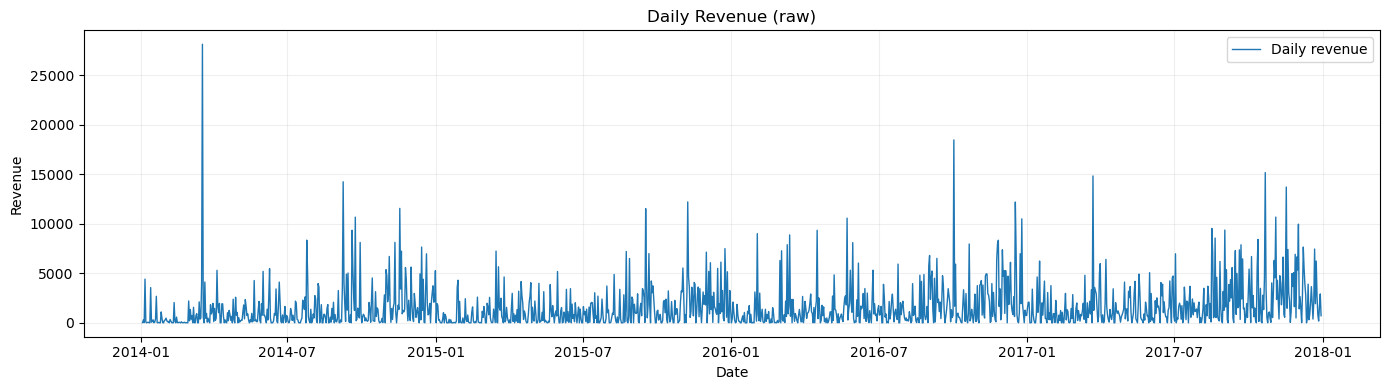

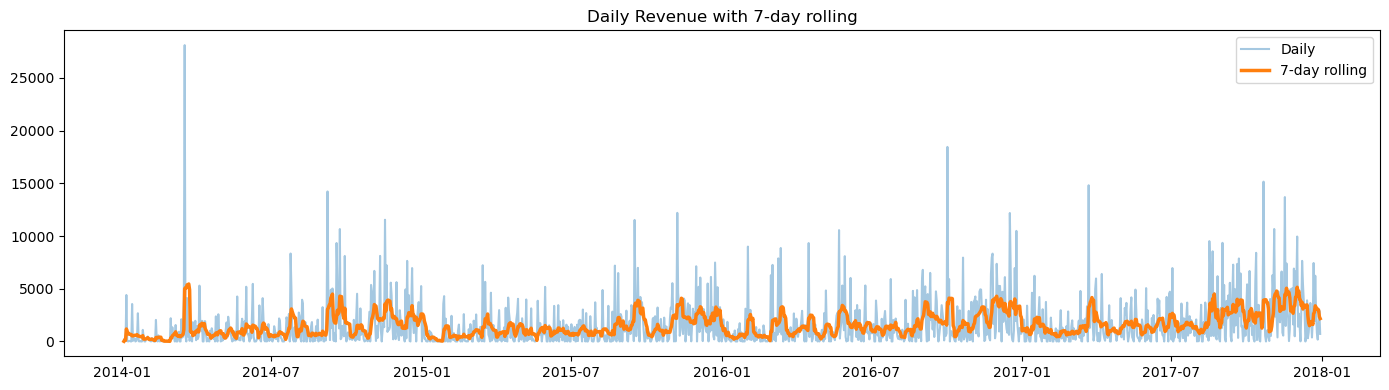

In [5]:
# Daily revenue
rev_daily = kpi.revenue_by_period(freq="D")
plt.figure(figsize=(14, 4))
plt.plot(rev_daily.index, rev_daily.values, label="Daily revenue", linewidth=1)
plt.title("Daily Revenue (raw)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

# 7-day rolling average overlay
rev_7 = rev_daily.rolling(window=7, min_periods=1).mean()
plt.figure(figsize=(14, 4))
plt.plot(rev_daily.index, rev_daily.values, alpha=0.4, label="Daily")
plt.plot(
    rev_7.index, rev_7.values, color="tab:orange", linewidth=2.5, label="7-day rolling"
)
plt.title("Daily Revenue with 7-day rolling")
plt.legend()
plt.tight_layout()
plt.show()

## 5) Weekly revenue + 4-week rolling (business view)


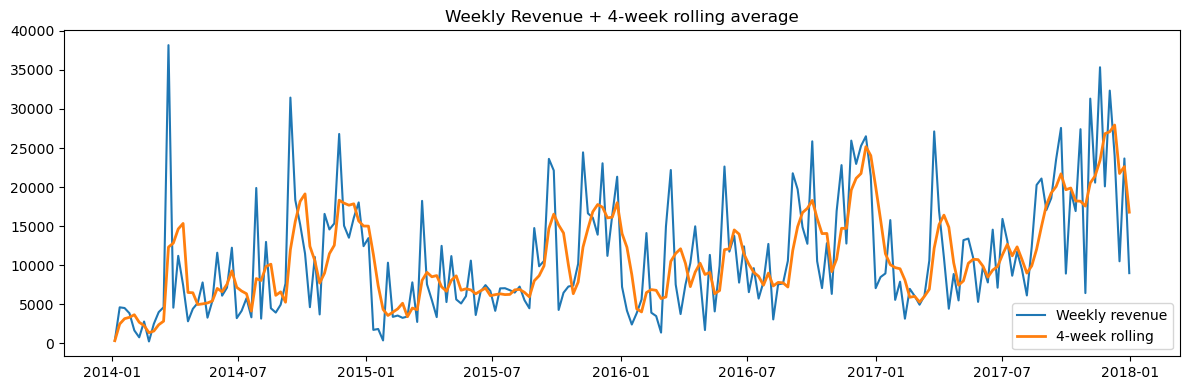

In [6]:
rev_weekly = kpi.revenue_by_period(freq="W")
rev_weekly_rolling = kpi.rolling_metric(rev_weekly, window=4)

plt.figure(figsize=(12, 4))
plt.plot(rev_weekly.index, rev_weekly.values, label="Weekly revenue")
plt.plot(
    rev_weekly_rolling.index,
    rev_weekly_rolling.values,
    label="4-week rolling",
    linewidth=2,
)
plt.title("Weekly Revenue + 4-week rolling average")
plt.legend()
plt.tight_layout()
plt.show()

## 6) Revenue breakdowns: Category & Region (top-N)


Top Categories by Revenue


,Category,Revenue
0,Technology,836154.0330
1,Furniture,741999.7953
2,Office Supplies,719047.0320


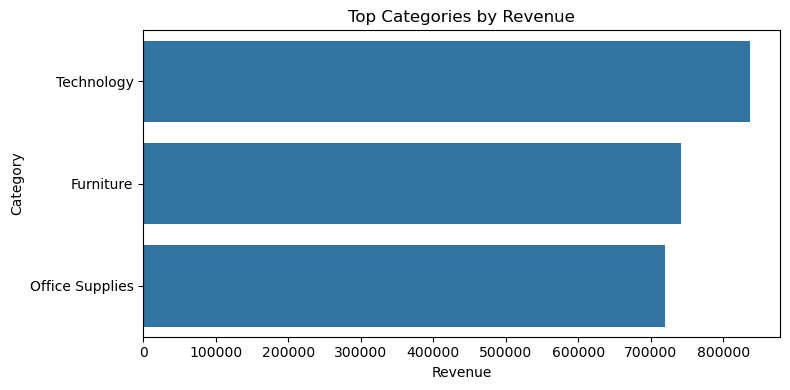

Top Regions by Revenue


,Region,Revenue
0,West,725457.8245
1,East,678781.2400
2,Central,501239.8908
3,South,391721.9050


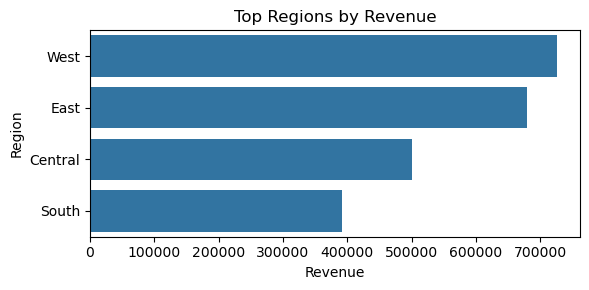

In [7]:
top_cats = kpi.revenue_by_category(n=10)
top_regs = kpi.revenue_by_region(n=10)

print("Top Categories by Revenue")
display(top_cats)

plt.figure(figsize=(8, 4))
sns.barplot(data=top_cats, x="Revenue", y="Category")
plt.title("Top Categories by Revenue")
plt.tight_layout()
plt.show()

print("Top Regions by Revenue")
display(top_regs)
plt.figure(figsize=(6, 3))
sns.barplot(data=top_regs, x="Revenue", y="Region")
plt.title("Top Regions by Revenue")
plt.tight_layout()
plt.show()

## 7) Negative-profit orders (loss-making orders) — quick audit


In [8]:
neg = kpi.negative_profit_orders(n=20)
print("Sample negative-profit orders:")
display(
    neg[["Order ID", "Customer ID", "Category", "Sales", "Profit", "Discount"]].head(10)
)

# Save to CSV for review
neg_path = OUTPUT_DIR / "loss_orders_sample.csv"
neg[["Order ID", "Customer ID", "Category", "Sales", "Profit", "Discount"]].to_csv(
    neg_path, index=False
)
print("Saved loss orders sample to", neg_path)

Sample negative-profit orders:


,Order ID,Customer ID,Category,Sales,Profit,Discount
7772,CA-2016-108196,CS-12505,Technology,4499.985,-6599.9780,0.7
683,US-2017-168116,GT-14635,Technology,7999.980,-3839.9904,0.5
9774,CA-2014-169019,LF-17185,Office Supplies,2177.584,-3701.8928,0.8
3011,CA-2017-134845,SR-20425,Technology,2549.985,-3399.9800,0.7
4991,US-2017-122714,HG-14965,Office Supplies,1889.990,-2929.4845,0.8
3151,CA-2015-147830,NF-18385,Technology,1799.994,-2639.9912,0.7
5310,CA-2017-131254,NC-18415,Office Supplies,1525.188,-2287.7820,0.8
9639,CA-2015-116638,JH-15985,Furniture,4297.644,-1862.3124,0.4
1199,CA-2016-130946,ZC-21910,Office Supplies,1088.792,-1850.9464,0.8
2697,CA-2014-145317,SM-20320,Technology,22638.480,-1811.0784,0.5


Saved loss orders sample to ..\outputs\loss_orders_sample.csv


## 8) Anomaly detection (z-score on daily revenue) — explainable candidates


In [9]:
zdf = kpi.revenue_zscore(freq="D")
# Compute absolute z and filter top outliers
zdf["abs_z"] = zdf["zscore"].abs()
top_outliers = zdf.sort_values("abs_z", ascending=False).head(20).reset_index(drop=True)
display(top_outliers.head(10))

# Save top outliers for agents
outliers_path = OUTPUT_DIR / "daily_revenue_outliers.csv"
top_outliers.to_csv(outliers_path, index=False)
print("Saved outliers to", outliers_path)

,period,revenue,zscore,abs_z
0,2014-03-18,28106.7160,11.925262,11.925262
1,2016-10-02,18452.9720,7.586080,7.586080
2,2017-10-22,15158.8770,6.105444,6.105444
3,2017-03-23,14816.0680,5.951357,5.951357
4,2014-09-08,14228.4280,5.687224,5.687224
5,2017-11-17,13694.8828,5.447405,5.447405
6,2015-11-08,12196.9970,4.774132,4.774132
7,2016-12-17,12185.1340,4.768800,4.768800
8,2014-11-17,11544.2740,4.480745,4.480745
9,2015-09-17,11525.0060,4.472085,4.472085


Saved outliers to ..\outputs\daily_revenue_outliers.csv


## 9) Dashboard payload for downstream agents (KPIAgent → InsightAgent)


In [10]:
payload = kpi.to_dashboard_payload()
# Add top daily outliers for context
payload["daily_outliers_sample"] = top_outliers.head(5).to_dict(orient="records")

payload_path = OUTPUT_DIR / "kpi_dashboard_payload.json"
with open(payload_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, indent=2, default=str)
print("Saved dashboard payload to:", payload_path)

# Print short payload summary
from pprint import pprint

pprint(
    {
        "summary": payload["summary"],
        "top_categories": payload["top_categories"][:3],
        "top_regions": payload["top_regions"][:3],
    }
)

Saved dashboard payload to: ..\outputs\kpi_dashboard_payload.json
{'summary': {'avg_order_value': 458.61,
             'orders_count': 5009,
             'profit_margin': 0.1247,
             'total_profit': 286397.02,
             'total_revenue': 2297200.86},
 'top_categories': [{'Category': 'Technology', 'Revenue': 836154.033},
                    {'Category': 'Furniture', 'Revenue': 741999.7953},
                    {'Category': 'Office Supplies', 'Revenue': 719047.032}],
 'top_regions': [{'Region': 'West', 'Revenue': 725457.8245},
                 {'Region': 'East', 'Revenue': 678781.24},
                 {'Region': 'Central', 'Revenue': 501239.8908}]}


## 10) Next steps & notes
- Next: build Anomaly Agent that consumes `daily_revenue_outliers.csv` and `kpi_dashboard_payload.json` and returns explanations + action recommendations.
- Optional: add seasonal decomposition, holiday effects, and forecasting.
- For production: add automated tests for KPIAgent, and provide type-checking & contract tests for dashboard payload.
